In [81]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [82]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = P2_GLOBAL #to be equivalent/same importance as having 0 stock or surpassing max capacity levels


## System initializer

In [83]:
def initialize_test_system(noise = False, seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = noise
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
#     for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
#         a = np.linspace(0,max_load, lvl+1)[1]
#         current_load = np.random.randint(a+1,max_load)
#         tank_current_loads[i] = current_load     

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [84]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
print(system.graph)
print(system.weights)

[35, 171, 67, 429, 42]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
[[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [85]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

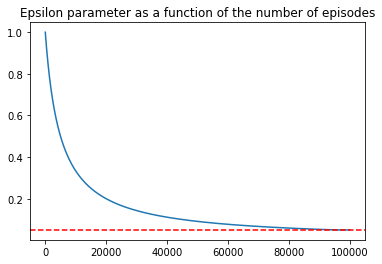

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 1*10**5
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 25

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(simulation_directory + '/Q-dictionaries')
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

    
ut.save_obj(toy_system, simulation_directory+"/system-sim"+f"{simulation_id}") 

# Output headers to file
with open(rewards_file,'w') as f:
     np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward, _,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward, _ ,_ = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward,_ ,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode}")   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total episodes: {n_episodes}. Elapsed time: {round(end_time/60., round_time)} minutes.")        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
if train_epsilon == True and retrain == False:
    episodic_train_Q_epsilon()
elif train_epsilon == False and retrain == True:
    Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode_retrain}")
    episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
else:
    raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    
    

Episode: 100. Elapsed time  0.05  minuts. epsilon 0.9806 Discounted reward:  -16.92315549995856
Episode: 200. Elapsed time  0.11  minuts. epsilon 0.9617 Discounted reward:  -18.480886845136798
Episode: 300. Elapsed time  0.19  minuts. epsilon 0.9436 Discounted reward:  -18.467507721124615
Episode: 400. Elapsed time  0.27  minuts. epsilon 0.9261 Discounted reward:  -11.898000467459262
Episode: 500. Elapsed time  0.36  minuts. epsilon 0.9093 Discounted reward:  -17.920363618385462
Episode: 600. Elapsed time  0.46  minuts. epsilon 0.893 Discounted reward:  -15.973534390903014
Episode: 700. Elapsed time  0.57  minuts. epsilon 0.8773 Discounted reward:  -22.082934283689656
Episode: 800. Elapsed time  0.68  minuts. epsilon 0.8622 Discounted reward:  -14.18605497924187
Episode: 900. Elapsed time  0.8  minuts. epsilon 0.8476 Discounted reward:  -13.847245235219148
Episode: 1000. Elapsed time  0.93  minuts. epsilon 0.8335 Discounted reward:  -20.602865860808887
Episode: 1100. Elapsed time  1.06

Episode: 8600. Elapsed time  41.05  minuts. epsilon 0.3677 Discounted reward:  -6.750744870083416
Episode: 8700. Elapsed time  41.39  minuts. epsilon 0.365 Discounted reward:  -2.7759416447352177
Episode: 8800. Elapsed time  41.73  minuts. epsilon 0.3623 Discounted reward:  -8.476008635983877
Episode: 8900. Elapsed time  42.07  minuts. epsilon 0.3597 Discounted reward:  -5.485658271816489
Episode: 9000. Elapsed time  42.43  minuts. epsilon 0.3572 Discounted reward:  -8.835201902855513
Episode: 9100. Elapsed time  42.79  minuts. epsilon 0.3546 Discounted reward:  -5.581578092076966
Episode: 9200. Elapsed time  43.13  minuts. epsilon 0.3521 Discounted reward:  -2.370029494593691
Episode: 9300. Elapsed time  43.47  minuts. epsilon 0.3497 Discounted reward:  -5.2423243029973206
Episode: 9400. Elapsed time  43.79  minuts. epsilon 0.3472 Discounted reward:  -5.413698258754675
Episode: 9500. Elapsed time  44.11  minuts. epsilon 0.3449 Discounted reward:  -9.292835508414129
Episode: 9600. Elap

Episode: 16900. Elapsed time  73.44  minuts. epsilon 0.2283 Discounted reward:  -3.2832334529886342
Episode: 17000. Elapsed time  73.87  minuts. epsilon 0.2273 Discounted reward:  -1.5018819239040717
Episode: 17100. Elapsed time  74.3  minuts. epsilon 0.2263 Discounted reward:  -7.282614248600238
Episode: 17200. Elapsed time  74.74  minuts. epsilon 0.2252 Discounted reward:  -1.8350490840085352
Episode: 17300. Elapsed time  75.15  minuts. epsilon 0.2242 Discounted reward:  -4.9639881832551165
Episode: 17400. Elapsed time  75.61  minuts. epsilon 0.2232 Discounted reward:  -4.414097903538592
Episode: 17500. Elapsed time  76.11  minuts. epsilon 0.2222 Discounted reward:  -1.0670972300097692
Episode: 17600. Elapsed time  76.52  minuts. epsilon 0.2212 Discounted reward:  -3.09945711747764
Episode: 17700. Elapsed time  76.94  minuts. epsilon 0.2203 Discounted reward:  -4.805596762988898
Episode: 17800. Elapsed time  77.37  minuts. epsilon 0.2193 Discounted reward:  -0.8985676483556668
Episod

Episode: 25200. Elapsed time  110.08  minuts. epsilon 0.1656 Discounted reward:  -4.39080317658525
Episode: 25300. Elapsed time  110.53  minuts. epsilon 0.165 Discounted reward:  -2.1225613246927666
Episode: 25400. Elapsed time  110.98  minuts. epsilon 0.1645 Discounted reward:  -0.9322728412959449
Episode: 25500. Elapsed time  111.42  minuts. epsilon 0.1639 Discounted reward:  -2.546480621487398
Episode: 25600. Elapsed time  111.85  minuts. epsilon 0.1634 Discounted reward:  -4.1805958108500985
Episode: 25700. Elapsed time  112.39  minuts. epsilon 0.1629 Discounted reward:  -0.6152123533248697
Episode: 25800. Elapsed time  112.87  minuts. epsilon 0.1623 Discounted reward:  -2.1163987578935215
Episode: 25900. Elapsed time  113.37  minuts. epsilon 0.1618 Discounted reward:  -4.486233684284122
Episode: 26000. Elapsed time  113.8  minuts. epsilon 0.1613 Discounted reward:  -0.1150814028557117
Episode: 26100. Elapsed time  114.23  minuts. epsilon 0.1608 Discounted reward:  -1.0918593034722

Episode: 33400. Elapsed time  148.97  minuts. epsilon 0.1302 Discounted reward:  -1.1553938426327635
Episode: 33500. Elapsed time  149.49  minuts. epsilon 0.1299 Discounted reward:  -1.6683661377576926
Episode: 33600. Elapsed time  150.02  minuts. epsilon 0.1295 Discounted reward:  -2.034625805755321
Episode: 33700. Elapsed time  150.63  minuts. epsilon 0.1292 Discounted reward:  -0.5705719631294267
Episode: 33800. Elapsed time  151.18  minuts. epsilon 0.1289 Discounted reward:  -1.4098091132594672
Episode: 33900. Elapsed time  151.66  minuts. epsilon 0.1285 Discounted reward:  -3.596045035517067
Episode: 34000. Elapsed time  152.14  minuts. epsilon 0.1282 Discounted reward:  -2.5887475335567998
Episode: 34100. Elapsed time  152.59  minuts. epsilon 0.1279 Discounted reward:  -3.1980084998926257
Episode: 34200. Elapsed time  153.09  minuts. epsilon 0.1276 Discounted reward:  -1.3828520870980048
Episode: 34300. Elapsed time  153.54  minuts. epsilon 0.1272 Discounted reward:  -1.444151865

Episode: 41600. Elapsed time  189.16  minuts. epsilon 0.1073 Discounted reward:  -0.49420702625391927
Episode: 41700. Elapsed time  189.68  minuts. epsilon 0.1071 Discounted reward:  -2.5224794772564834
Episode: 41800. Elapsed time  190.19  minuts. epsilon 0.1068 Discounted reward:  -1.2748531311270273
Episode: 41900. Elapsed time  190.63  minuts. epsilon 0.1066 Discounted reward:  -0.07886237090078997
Episode: 42000. Elapsed time  191.1  minuts. epsilon 0.1064 Discounted reward:  -0.15985761223640638
Episode: 42100. Elapsed time  191.64  minuts. epsilon 0.1062 Discounted reward:  -1.4548614953649035
Episode: 42200. Elapsed time  192.11  minuts. epsilon 0.1059 Discounted reward:  -2.2962586821166484
Episode: 42300. Elapsed time  192.55  minuts. epsilon 0.1057 Discounted reward:  -2.109037190470689
Episode: 42400. Elapsed time  193.04  minuts. epsilon 0.1055 Discounted reward:  -0.7470896688152782
Episode: 42500. Elapsed time  193.48  minuts. epsilon 0.1053 Discounted reward:  -1.102284

Episode: 49800. Elapsed time  229.26  minuts. epsilon 0.0912 Discounted reward:  -2.0540256115195374
Episode: 49900. Elapsed time  229.78  minuts. epsilon 0.0911 Discounted reward:  -1.6425928888440429
Episode: 50000. Elapsed time  230.29  minuts. epsilon 0.0909 Discounted reward:  -1.204692765574289
Episode: 50100. Elapsed time  230.86  minuts. epsilon 0.0907 Discounted reward:  -1.693976278530673
Episode: 50200. Elapsed time  231.33  minuts. epsilon 0.0906 Discounted reward:  -0.005738612741682509
Episode: 50300. Elapsed time  231.82  minuts. epsilon 0.0904 Discounted reward:  -3.441851548629332
Episode: 50400. Elapsed time  232.28  minuts. epsilon 0.0903 Discounted reward:  -1.031553744053494
Episode: 50500. Elapsed time  232.75  minuts. epsilon 0.0901 Discounted reward:  -2.5222289088503342
Episode: 50600. Elapsed time  233.24  minuts. epsilon 0.0899 Discounted reward:  -0.3564819112796046
Episode: 50700. Elapsed time  233.74  minuts. epsilon 0.0898 Discounted reward:  -2.222412823

Episode: 58000. Elapsed time  270.31  minuts. epsilon 0.0794 Discounted reward:  -1.9876313538543406
Episode: 58100. Elapsed time  270.76  minuts. epsilon 0.0792 Discounted reward:  -1.069069953053184
Episode: 58200. Elapsed time  271.22  minuts. epsilon 0.0791 Discounted reward:  -0.008601341835008608
Episode: 58300. Elapsed time  271.7  minuts. epsilon 0.079 Discounted reward:  -0.15618361593118477
Episode: 58400. Elapsed time  272.15  minuts. epsilon 0.0789 Discounted reward:  -0.11120750798493925
Episode: 58500. Elapsed time  272.64  minuts. epsilon 0.0787 Discounted reward:  -0.39998988881137665
Episode: 58600. Elapsed time  273.17  minuts. epsilon 0.0786 Discounted reward:  -0.3205793080192362
Episode: 58700. Elapsed time  273.66  minuts. epsilon 0.0785 Discounted reward:  -2.5169602681600534
Episode: 58800. Elapsed time  274.15  minuts. epsilon 0.0784 Discounted reward:  -1.964869272507517
Episode: 58900. Elapsed time  274.61  minuts. epsilon 0.0782 Discounted reward:  -0.624984

Episode: 66100. Elapsed time  311.03  minuts. epsilon 0.0703 Discounted reward:  -0.39576118052073284
Episode: 66200. Elapsed time  311.57  minuts. epsilon 0.0702 Discounted reward:  -1.4028938337302705
Episode: 66300. Elapsed time  312.03  minuts. epsilon 0.0701 Discounted reward:  -0.006420463980041288
Episode: 66400. Elapsed time  312.59  minuts. epsilon 0.07 Discounted reward:  -0.7085919652051013
Episode: 66500. Elapsed time  313.11  minuts. epsilon 0.0699 Discounted reward:  -0.14917898233168017
Episode: 66600. Elapsed time  313.57  minuts. epsilon 0.0698 Discounted reward:  -0.003674969994311576
Episode: 66700. Elapsed time  314.05  minuts. epsilon 0.0697 Discounted reward:  -0.052293694239852175
Episode: 66800. Elapsed time  314.56  minuts. epsilon 0.0696 Discounted reward:  -0.003694169163259405
Episode: 66900. Elapsed time  315.1  minuts. epsilon 0.0695 Discounted reward:  -0.28831940862821115
Episode: 67000. Elapsed time  315.63  minuts. epsilon 0.0694 Discounted reward:  -1

Episode: 74200. Elapsed time  351.74  minuts. epsilon 0.0631 Discounted reward:  -1.1110421573519114
Episode: 74300. Elapsed time  352.21  minuts. epsilon 0.0631 Discounted reward:  -0.5464691743550588
Episode: 74400. Elapsed time  352.68  minuts. epsilon 0.063 Discounted reward:  -1.7549572277731995
Episode: 74500. Elapsed time  353.15  minuts. epsilon 0.0629 Discounted reward:  -2.5781337683121417
Episode: 74600. Elapsed time  353.62  minuts. epsilon 0.0628 Discounted reward:  -0.5164571903456792
Episode: 74700. Elapsed time  354.11  minuts. epsilon 0.0627 Discounted reward:  -1.261094931060353
Episode: 74800. Elapsed time  354.57  minuts. epsilon 0.0627 Discounted reward:  -1.1394532279590601
Episode: 74900. Elapsed time  355.07  minuts. epsilon 0.0626 Discounted reward:  -0.21881452253916306
Episode: 75000. Elapsed time  355.54  minuts. epsilon 0.0625 Discounted reward:  -1.1200771329405814
Episode: 75100. Elapsed time  356.01  minuts. epsilon 0.0624 Discounted reward:  -1.65089842

Episode: 82300. Elapsed time  392.84  minuts. epsilon 0.0573 Discounted reward:  -2.1543616389471483
Episode: 82400. Elapsed time  393.36  minuts. epsilon 0.0572 Discounted reward:  -0.08690650321164248
Episode: 82500. Elapsed time  393.86  minuts. epsilon 0.0571 Discounted reward:  -1.3208560792916388
Episode: 82600. Elapsed time  394.39  minuts. epsilon 0.0571 Discounted reward:  -0.7825700806201096
Episode: 82700. Elapsed time  394.93  minuts. epsilon 0.057 Discounted reward:  -0.4255858895503312
Episode: 82800. Elapsed time  395.45  minuts. epsilon 0.0569 Discounted reward:  -0.7182038110984966
Episode: 82900. Elapsed time  395.99  minuts. epsilon 0.0569 Discounted reward:  -0.9169171426756504
Episode: 83000. Elapsed time  396.54  minuts. epsilon 0.0568 Discounted reward:  -0.005787089310594516
Episode: 83100. Elapsed time  397.13  minuts. epsilon 0.0568 Discounted reward:  -3.405415315200391
Episode: 83200. Elapsed time  397.68  minuts. epsilon 0.0567 Discounted reward:  -0.518409

Episode: 90400. Elapsed time  435.11  minuts. epsilon 0.0524 Discounted reward:  -0.19466219671699006
Episode: 90500. Elapsed time  435.62  minuts. epsilon 0.0524 Discounted reward:  -1.920013035188254
Episode: 90600. Elapsed time  436.1  minuts. epsilon 0.0523 Discounted reward:  -2.4600421989133205
Episode: 90700. Elapsed time  436.62  minuts. epsilon 0.0522 Discounted reward:  -2.4852753719449505
Episode: 90800. Elapsed time  437.11  minuts. epsilon 0.0522 Discounted reward:  -0.006327985251276792
Episode: 90900. Elapsed time  437.58  minuts. epsilon 0.0521 Discounted reward:  -0.006529052561292276
Episode: 91000. Elapsed time  438.05  minuts. epsilon 0.0521 Discounted reward:  -0.004919964203557274
Episode: 91100. Elapsed time  438.54  minuts. epsilon 0.052 Discounted reward:  -0.3767836329130819
Episode: 91200. Elapsed time  439.14  minuts. epsilon 0.052 Discounted reward:  -0.3539991803134221
Episode: 91300. Elapsed time  439.65  minuts. epsilon 0.0519 Discounted reward:  -1.2893

Episode: 98600. Elapsed time  478.38  minuts. epsilon 0.05 Discounted reward:  -0.7259888877226839
Episode: 98700. Elapsed time  479.0  minuts. epsilon 0.05 Discounted reward:  -0.009132201165468078
Episode: 98800. Elapsed time  479.57  minuts. epsilon 0.05 Discounted reward:  -1.2627498711585279
Episode: 98900. Elapsed time  480.1  minuts. epsilon 0.05 Discounted reward:  -0.11509594450215056
Episode: 99000. Elapsed time  480.65  minuts. epsilon 0.05 Discounted reward:  -0.23615012316270112
Episode: 99100. Elapsed time  481.19  minuts. epsilon 0.05 Discounted reward:  -0.3794535305141175
Episode: 99200. Elapsed time  481.75  minuts. epsilon 0.05 Discounted reward:  -0.0038468181617574817
Episode: 99300. Elapsed time  482.32  minuts. epsilon 0.05 Discounted reward:  -1.5897821881215393
Episode: 99400. Elapsed time  482.9  minuts. epsilon 0.05 Discounted reward:  -0.39335164893478713
Episode: 99500. Elapsed time  483.46  minuts. epsilon 0.05 Discounted reward:  -0.694084350595154
Episod

### Testing

In [86]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
#episodes = 100000#243000
#simulation_id = 16 # comment when training
#simulation_directory = './simulations/simulation{}'.format(simulation_id) # comment when training


tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


test_episodes = 5
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []
test_number_of_first_trucks_sent_list = []
test_number_of_second_trucks_sent_list = []

In [87]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list =test_number_of_first_trucks_sent_list,
           number_of_second_trucks_sent_list = test_number_of_second_trucks_sent_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}\n".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0 
        transport_rewards = 0
        level_rewards = 0
        number_of_trucks_sent = 0
        number_of_first_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_second_trucks_sent = np.zeros(n+1, dtype = np.int64)

        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode-1)*(episode_length)+i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward, transport_reward, level_reward = system.random_action()
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, round(reward,7), round(level_reward,7), round(transport_reward,7), "\nRandom action is performed. Current state unknown for Q.")

            else:
                reward, transport_reward, level_reward = system.deterministic_action(best_action)
                number_of_trucks_sent = number_of_trucks_sent + best_action.count('5')
                index1 = int(best_action[0])
                number_of_first_trucks_sent[index1] = number_of_first_trucks_sent[index1] + 1
                index2 = int(best_action[1])
                number_of_second_trucks_sent[index2] = number_of_second_trucks_sent[index2] + 1
                
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,round(reward,7),round(level_reward,7), round(transport_reward,7), best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            transport_rewards = transport_rewards+transport_reward
            level_rewards = level_rewards + level_reward
            
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);
            transport_rewards_list.append(transport_rewards);
            level_rewards_list.append(level_rewards);
            trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);
            number_of_first_trucks_sent_list.append(number_of_first_trucks_sent);
            number_of_second_trucks_sent_list.append(number_of_second_trucks_sent);






Test episode: 1
Test episode: 2
Test episode: 3
Test episode: 4
Test episode: 5


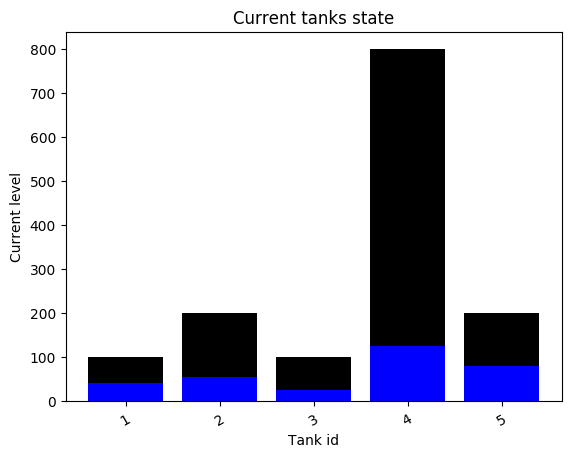

In [88]:
test_Q()
#print(np.mean(test_rewards_list) )

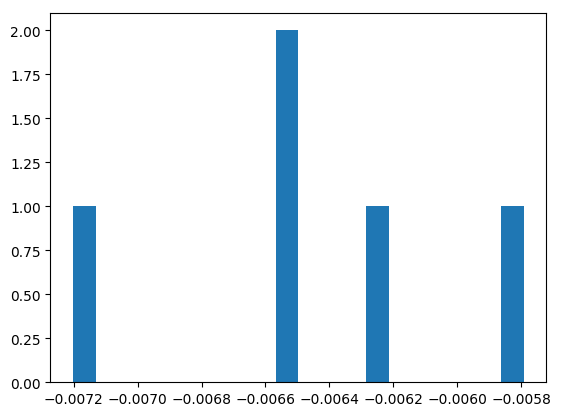

In [51]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

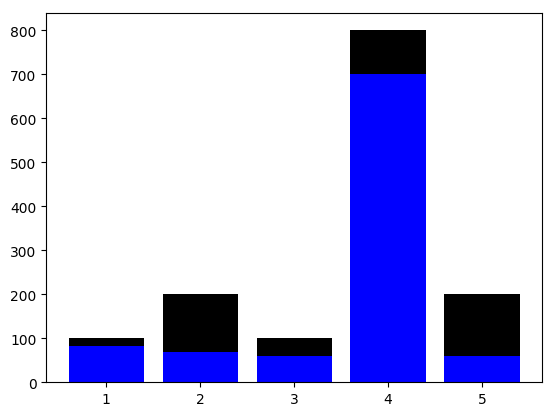

In [52]:
# Visualizing test simulation:

test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
HTML(test_anim.to_html5_video())


/home/dsalgador/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


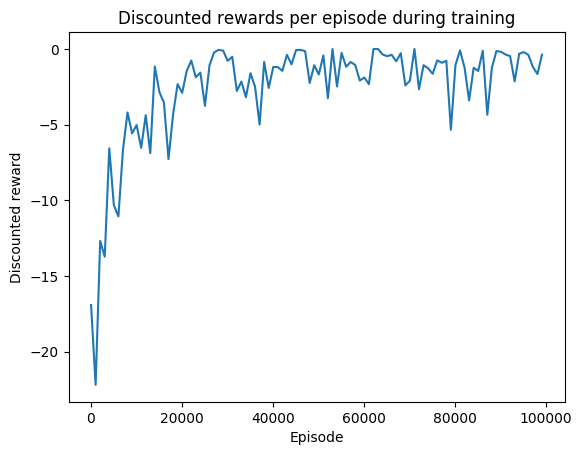

In [53]:
# Visualizing train simulation:

episode =episodes
#simulation_id = 2
step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

indices = [i for i in range(0,100000,10)]

plt.plot(discrewards['episode'][indices],discrewards['discreward'][indices], label = "Discounted rewards")
plt.title("Discounted rewards per episode during training")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")

plt.show()
plt.close()


In [54]:
discrewards['episode'][ [i for i in range(10)]]

0     100
1     200
2     300
3     400
4     500
5     600
6     700
7     800
8     900
9    1000
Name: episode, dtype: int64

In [55]:
len(list(Q))

28320

In [56]:
tank_levels = [test_visualization_steps[i][2] for i in range(len(test_visualization_steps))]
tank_levels_array = np.asarray(tank_levels).transpose()

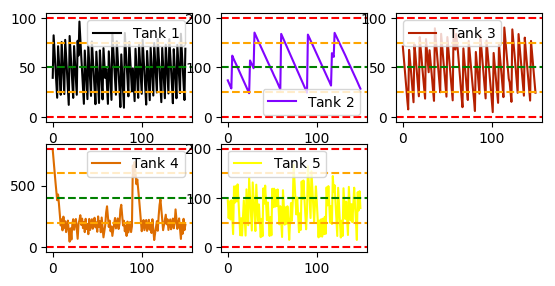

In [57]:
#DISCRETE LEVELS

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    
    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].levels):
        plt.axhline(y= lvl, xmin=0, xmax=episode_length, hold=None, color = lvl_color, linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


    plt.legend(loc='best')
plt.show()

        

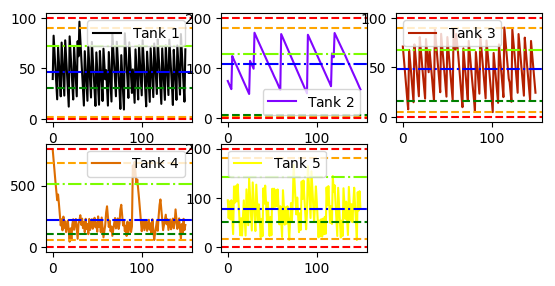

In [58]:
# THE REAL LEVELS (percentages 12h, 36h, ? h)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    

    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
        plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = tanks[i-1].level_percentages           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(tank_levels_array[i-1]), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
  


    plt.legend(loc='best')
#plt.show()
plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')

### Test visualization

In [89]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    tanks = test_toy_system.tanks

    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
            plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = tanks[i-1].level_percentages           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length+1,5))


    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')
    plt.show()
    plt.close()


## Simulations

In [91]:

def test_simulation(simulation_id,
                   max_episodes,
                   n_episodes = 1,
                   noise = False):
    
    # Initialize directories and files
    
    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
    
    with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

    # Initialize system
    episodes = max_episodes#100000

    tanks, trucks, graph, weights_matrix = initialize_test_system(noise, seed =episodes+1)
    test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

    Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


    test_episodes = n_episodes
    episode_length =30
    test_freq = 1
    test_verbose = True

    test_visualization_steps = []
    test_rewards_list = []
    test_level_rewards_list = []
    test_transport_rewards_list = []
    test_trucks_sent_list = []
    test_number_of_first_trucks_sent_list = []
    test_number_of_second_trucks_sent_list = []
    
        
    test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list = test_number_of_first_trucks_sent_list,           
           number_of_second_trucks_sent_list=test_number_of_second_trucks_sent_list,           
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q 
          )
            
    visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory)   
    print("Total discounted rewards","Level rewards", "Transport rewards")
    print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
    print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)
    
    if n_episodes == 1:
        print("1st type Trucks sent to each shop:", test_number_of_first_trucks_sent_list)
        print("2nd type Trucks sent to each shop:", test_number_of_second_trucks_sent_list)

    
test_episodes = 1

### Deterministic consumption rates without transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -0.0018445 -0.0006827 0.0011618 0300
Episode 1 t 2 -0.0015889 3.16e-05 0.0016205 1400
Episode 1 t 3 -0.0005347 2.87e-05 0.0005634 4500
Episode 1 t 4 0.0001636 0.0001636 0.0 5500
Episode 1 t 5 -0.0008969 0.0007344 0.0016313 2300
Episode 1 t 6 -8.01e-05 3.55e-05 0.0001156 0500
Episode 1 t 7 0.0008252 0.0008252 0.0 5500
Episode 1 t 8 -0.0015824 2.72e-05 0.0016096 3400
Episode 1 t 9 0.0005864 0.0005864 0.0 5500
Episode 1 t 10 -0.0011384 2.34e-05 0.0011618 0400
Episode 1 t 11 -0.0015125 9.71e-05 0.0016096 3300
Episode 1 t 12 -0.001606 2.53e-05 0.0016313 2300
Episode 1 t 13 0.00045 0.00045 0.0 5500
Episode 1 t 14 -0.0005228 0.0006391 0.0011618 0300
Episode 1 t 15 -0.0015801 2.95e-05 0.0016096 3400
Episode 1 t 16 -0.0015889 2.07e-05 0.0016096 4300
Episode 1 t 17 0.0003097 0.0003097 0.0 5500
Episode 1 t 18 -0.0011833 1.88e-05 0.0012021 0200
Episode 1 t 19 -0.0015883 2.13e-05 0.0016096 3300
Episode 1 t 20 0.000741 0.0007

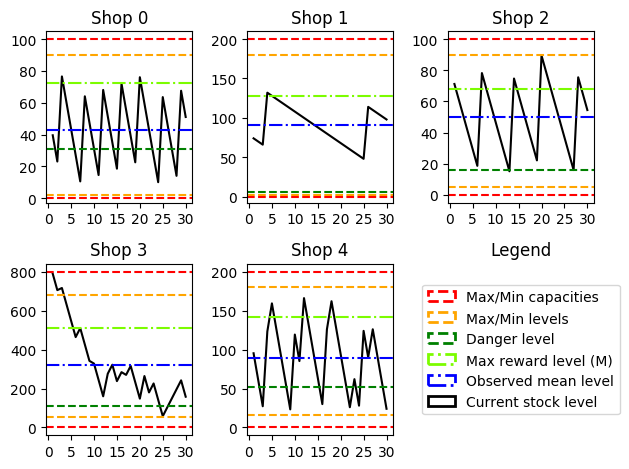

Total discounted rewards Level rewards Transport rewards
-0.007425479316545746 0.007396137580054166 0.028702136939999984
Average trucks sent:  40.0
1st type Trucks sent to each shop: [array([7, 2, 3, 4, 5, 9])]
2nd type Trucks sent to each shop: [array([ 0,  0,  1, 13,  5, 11])]


In [92]:
test_simulation(simulation_id= 16, max_episodes = 100000,n_episodes = test_episodes)


### Deterministic consumption rates WITH transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -0.0018445 -0.0006827 0.0011618 0300
Episode 1 t 2 -0.001634 1.59e-05 0.0016499 4200
Episode 1 t 3 0.0006521 0.0006521 0.0 5500
Episode 1 t 4 -0.000403 0.0001603 0.0005634 4500
Episode 1 t 5 0.0013004 0.0013004 0.0 5500
Episode 1 t 6 -1.0016166 -0.9999868 0.0016298 4100
Episode 1 t 7 -0.000624 0.0005378 0.0011618 0300
Episode 1 t 8 -0.001595 1.47e-05 0.0016096 4300
Episode 1 t 9 -0.0002076 0.0008387 0.0010463 5300
Episode 1 t 10 -0.0001796 0.0009823 0.0011618 0400
Episode 1 t 11 -0.0005556 2.94e-05 0.000585 2500
Episode 1 t 12 -0.0015872 2.24e-05 0.0016096 3400
Episode 1 t 13 0.000246 0.000246 0.0 5500
Episode 1 t 14 -0.0011371 2.48e-05 0.0011618 0300
Episode 1 t 15 1.82e-05 1.82e-05 0.0 5500
Episode 1 t 16 -0.0010034 0.0006279 0.0016313 2300
Episode 1 t 17 -0.0015018 0.0001079 0.0016096 4300
Episode 1 t 18 0.0012301 0.0012301 0.0 5500
Episode 1 t 19 -0.0021574 -0.0009956 0.0011618 0400
Episode 1 t 20 -0.001585 

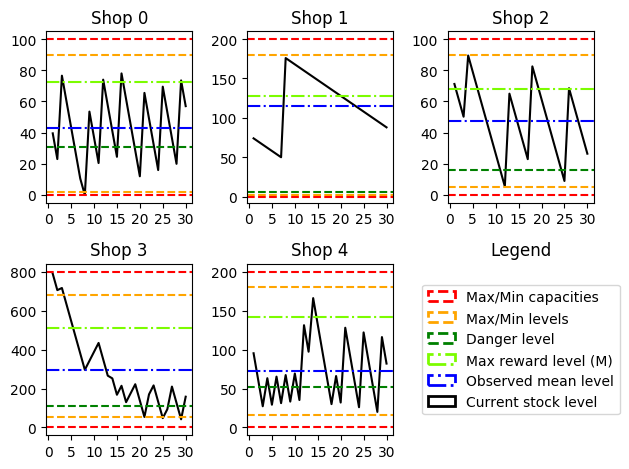

Total discounted rewards Level rewards Transport rewards
-0.5384555705209366 -0.9944471905707256 0.028620107249999985
Average trucks sent:  39.0
1st type Trucks sent to each shop: [array([ 7,  0,  3,  4,  5, 11])]
2nd type Trucks sent to each shop: [array([ 0,  1,  1, 13,  5, 10])]


In [93]:
test_simulation(simulation_id= 17, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -0.0018445 -0.0006827 0.0011618 0300
Episode 1 t 2 -0.0015889 3.16e-05 0.0016205 1400
Episode 1 t 3 2.75e-05 2.75e-05 0.0 5500
Episode 1 t 4 0.0001558 0.0001558 0.0 5500
Episode 1 t 5 0.0009961 0.0015811 0.000585 2500
Episode 1 t 6 -0.0011229 3.89e-05 0.0011618 0400
Episode 1 t 7 2.67e-05 2.67e-05 0.0 5500
Episode 1 t 8 9.13e-05 9.13e-05 0.0 5500
Episode 1 t 9 -0.001025 0.0005846 0.0016096 4300
Episode 1 t 10 -0.0011195 4.23e-05 0.0011618 0300
Episode 1 t 11 0.0010502 0.0010502 0.0 5500
Episode 1 t 12 -0.0026479 -0.0010383 0.0016096 4300
Episode 1 t 13 -0.000273 0.0013583 0.0016313 2300
Episode 1 t 14 -0.0011303 3.15e-05 0.0011618 0400
Episode 1 t 15 -0.0010238 2.25e-05 0.0010463 5300
Episode 1 t 16 -0.0009001 0.0001462 0.0010463 5300
Episode 1 t 17 -0.0002607 0.0003027 0.0005634 4500
Episode 1 t 18 0.0009308 0.001261 0.0003302 0000
Episode 1 t 19 -0.0126347 -0.0110251 0.0016096 4300
Episode 1 t 20 -0.0015913 4e

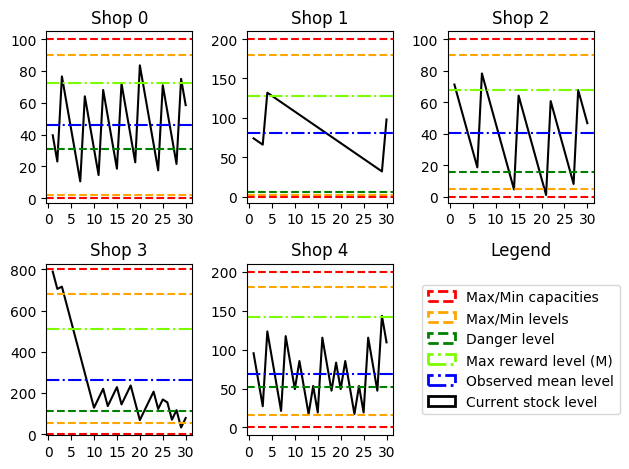

Total discounted rewards Level rewards Transport rewards
-0.007833812619698295 -0.0036518515742274137 0.027771435299999984
Average trucks sent:  39.0
1st type Trucks sent to each shop: [array([ 7,  2,  4,  1,  5, 11])]
2nd type Trucks sent to each shop: [array([ 1,  0,  0, 14,  5, 10])]


In [94]:
test_simulation(simulation_id= 18, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 -0.0008557 -0.0008557 0.0 5500
Episode 1 t 1 0.0016588 0.0016588 0.0 5500
Episode 1 t 2 -1.0000907 -0.9999751 0.0001156 0500
Episode 1 t 3 -0.9999814 -0.9999814 0.0 5500
Episode 1 t 4 -0.999918 -0.999918 0.0 5500
Episode 1 t 5 -0.9985381 -0.9985381 0.0 5500
Episode 1 t 6 -2.999994 -2.999994 0.0 5500
Episode 1 t 7 -2.9999966 -2.9999966 0.0 5500
Episode 1 t 8 -3.0011558 -3.0011558 0.0 5500
Episode 1 t 9 -3.9999977 -3.9999977 0.0 5500
Episode 1 t 10 -3.999998 -3.999998 0.0 5500
Episode 1 t 11 -3.9999984 -3.9999984 0.0 5500
Episode 1 t 12 -3.9999987 -3.9999987 0.0 5500
Episode 1 t 13 -3.999999 -3.999999 0.0 5500
Episode 1 t 14 -3.9999994 -3.9999994 0.0 5500
Episode 1 t 15 -3.9999997 -3.9999997 0.0 5500
Episode 1 t 16 -3.9999824 -3.9999824 0.0 5500
Episode 1 t 17 -4.001 -4.001 0.0 5500
Episode 1 t 18 -5.0 -5.0 0.0 5500
Episode 1 t 19 -5.0 -5.0 0.0 5500
Episode 1 t 20 -5.0 -5.0 0.0 5500
Episode 1 t 21 -5.0 -5.0 0.0 5500
Episode 1 t 22 -5.0 -5.0 0.0 5500
Episode 

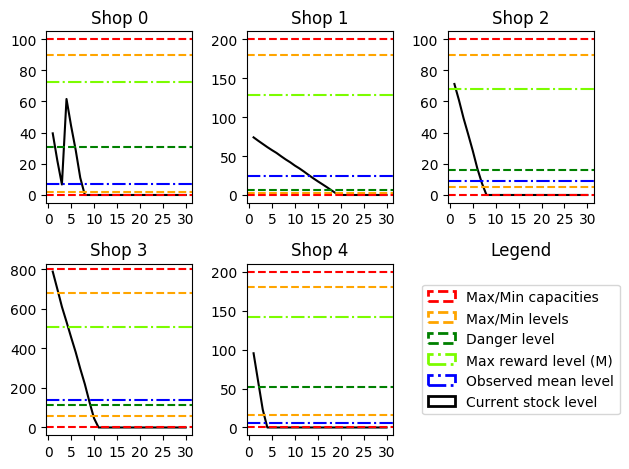

Total discounted rewards Level rewards Transport rewards
-21.983572286960456 -108.99972928684025 0.00011556383999999998
Average trucks sent:  1.0
1st type Trucks sent to each shop: [array([ 1,  0,  0,  0,  0, 29])]
2nd type Trucks sent to each shop: [array([ 0,  0,  0,  0,  0, 30])]


In [66]:
test_simulation(simulation_id= 21, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 0.001546 0.001546 0.0 5500
Episode 1 t 2 -1.0001934 -0.9999788 0.0002146 5000
Episode 1 t 3 -9.48e-05 0.0004686 0.0005634 4500
Episode 1 t 4 -0.0005455 1.79e-05 0.0005634 4500
Episode 1 t 5 -0.0001822 0.0004029 0.000585 2500
Episode 1 t 6 -0.0005561 0.0004902 0.0010463 5400
Episode 1 t 7 -0.0001946 2.01e-05 0.0002146 5000
Episode 1 t 8 -0.0016913 -0.0016913 0.0 5500
Episode 1 t 9 -1.000002 -0.9994278 0.0005742 1500
Episode 1 t 10 -1.0005513 -0.9999879 0.0005634 4500
Episode 1 t 11 -0.9989554 -0.9989554 0.0 5500
Episode 1 t 12 -2.0011471 -2.0010315 0.0001156 0500
Episode 1 t 13 -2.0001065 -1.9995431 0.0005634 4500
Episode 1 t 14 -2.000553 -1.9999897 0.0005634 4500
Episode 1 t 15 -0.9998541 -0.9992691 0.000585 2500
Episode 1 t 16 -1.010095 -1.0099794 0.0001156 0500
Episode 1 t 17 -1.0002136 -0.9996503 0.0005634 4500
Episode 1 t 18 -1.0005506 -0.9999873 0.0005634 4500
Episode 1 t 19 -0.9995275 -0.9995275 0.0 5500
E

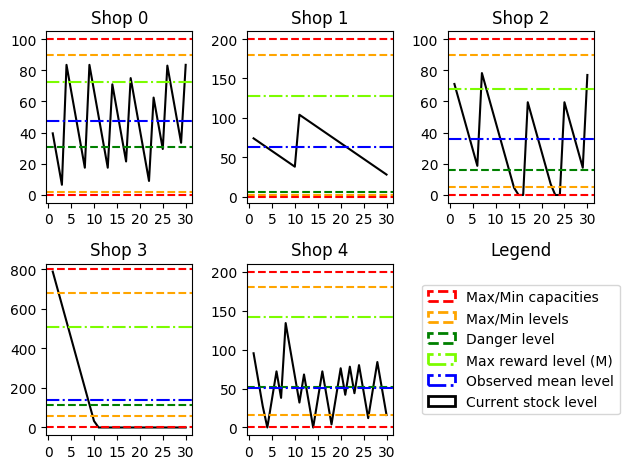

Total discounted rewards Level rewards Transport rewards
-5.237299779819028 -27.004997095910134 0.011827236749999994
Average trucks sent:  25.0
1st type Trucks sent to each shop: [array([ 4,  1,  4,  0, 12,  9])]
2nd type Trucks sent to each shop: [array([ 3,  0,  0,  0,  1, 26])]


In [96]:
test_simulation(simulation_id= 22, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 -0.0008557 -0.0008557 0.0 5500
Episode 1 t 1 -0.0016277 -0.0004658 0.0011618 0300
Episode 1 t 2 -0.9999809 -0.9999809 0.0 5500
Episode 1 t 3 -0.0001825 0.0003809 0.0005634 4500
Episode 1 t 4 -0.0004764 8.69e-05 0.0005634 4500
Episode 1 t 5 0.0004427 0.0010277 0.000585 2500
Episode 1 t 6 -0.0011256 3.63e-05 0.0011618 0400
Episode 1 t 7 -0.0005442 3e-05 0.0005742 1500
Episode 1 t 8 1.73e-05 1.73e-05 0.0 5500
Episode 1 t 9 -5.9e-05 0.0009872 0.0010463 5300
Episode 1 t 10 -1.0004515 -0.9998881 0.0005634 4500
Episode 1 t 11 -0.0006663 0.0004955 0.0011618 0300
Episode 1 t 12 -1.001032 -1.0004578 0.0005742 1500
Episode 1 t 13 -1.0019002 -1.0002504 0.0016499 4200
Episode 1 t 14 -1.0011342 -0.9999723 0.0011618 0400
Episode 1 t 15 -0.0024135 -0.0013672 0.0010463 5300
Episode 1 t 16 -0.0006876 0.0003586 0.0010463 5300
Episode 1 t 17 -0.0001273 0.000919 0.0010463 5300
Episode 1 t 18 -0.0007254 -0.0001621 0.0005634 4500
Episode 1 t 19 -6.98e-05 0.001092 0.0011618 0300


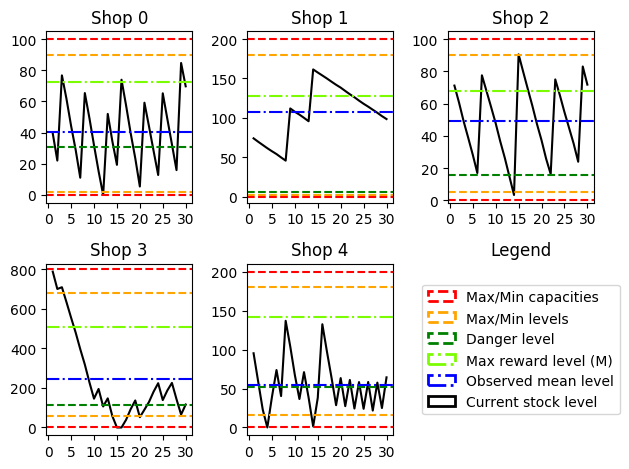

Total discounted rewards Level rewards Transport rewards
-1.9301020972335028 -4.9920408930446385 0.027272034419999987
Average trucks sent:  39.0
1st type Trucks sent to each shop: [array([ 6,  2,  3,  0, 10,  9])]
2nd type Trucks sent to each shop: [array([ 1,  0,  1, 14,  2, 12])]


In [79]:
test_simulation(simulation_id= 23, max_episodes = 100000, n_episodes = test_episodes)

### Stochastic consumption rates without transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0008557 -0.0008557 0.0 5500
Episode 1 t 1 -0.001132 2.99e-05 0.0011618 0400
Episode 1 t 2 3.21e-05 3.21e-05 0.0 5500
Episode 1 t 3 2.23e-05 2.23e-05 0.0 5500
Episode 1 t 4 -0.000435 0.0001392 0.0005742 1500
Episode 1 t 5 0.0014048 0.002451 0.0010463 5300
Episode 1 t 6 -1.0011317 -0.9999699 0.0011618 0400
Episode 1 t 7 -0.0005565 2.86e-05 0.000585 2500
Episode 1 t 8 -0.0005397 2.37e-05 0.0005634 4500
Episode 1 t 9 -0.0010462 0.0005634 0.0016096 3300
Episode 1 t 10 -0.0010101 0.0001517 0.0011618 0300
Episode 1 t 11 -0.0015831 2.65e-05 0.0016096 3400
Episode 1 t 12 -0.001605 2.63e-05 0.0016313 2300
Episode 1 t 13 0.0004893 0.0004893 0.0 5500
Episode 1 t 14 -0.000768 0.0003938 0.0011618 0300
Episode 1 t 15 -0.0015781 3.15e-05 0.0016096 3400
Episode 1 t 16 1.92e-05 1.92e-05 0.0 5500
Episode 1 t 17 0.000329 0.000329 0.0 5500
Episode 1 t 18 0.0007983 0.0018446 0.0010463 5300
Episode 1 t 19 -1.0068432 -1.0056814 0.0011618 0300
Episode 1 t 20 -0.0016101 2.12e-05

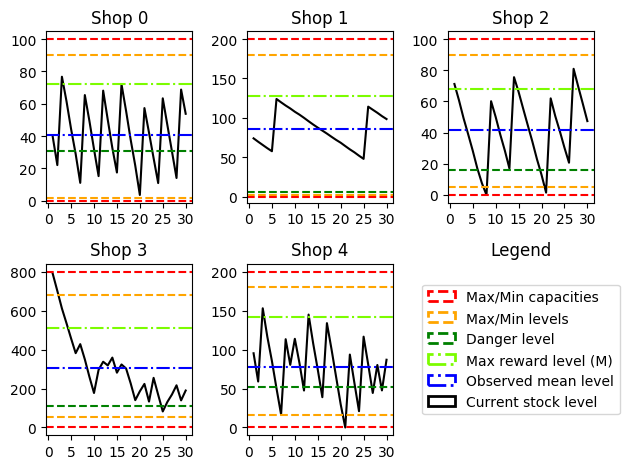

Total discounted rewards Level rewards Transport rewards
-0.6724453144258384 -1.9965314954692288 0.028683564179999982
Average trucks sent:  40.0
1st type Trucks sent to each shop: [array([7, 2, 4, 4, 4, 9])]
2nd type Trucks sent to each shop: [array([ 0,  0,  0, 13,  6, 11])]


In [97]:
test_simulation(simulation_id= 14, max_episodes = 100000,n_episodes = test_episodes, noise = True)

Test episode: 1
Episode 1 t 0 -0.0008557 -0.0008557 0.0 5500
Episode 1 t 1 -0.0016277 -0.0004658 0.0011618 0300
Episode 1 t 2 -0.0007629 1.51e-05 0.000778 4000
Episode 1 t 3 -0.0005358 2.76e-05 0.0005634 4500
Episode 1 t 4 -0.0005361 2.73e-05 0.0005634 4500
Episode 1 t 5 -0.0005629 2.22e-05 0.000585 2500
Episode 1 t 6 -0.0011531 0.0004565 0.0016096 4300
Episode 1 t 7 -8.31e-05 3.25e-05 0.0001156 0500
Episode 1 t 8 -0.0015914 2.91e-05 0.0016205 1300
Episode 1 t 9 -0.0010226 2.37e-05 0.0010463 5400
Episode 1 t 10 0.0003524 0.0003524 0.0 5500
Episode 1 t 11 1.38e-05 0.0001293 0.0001156 0500
Episode 1 t 12 -0.0016082 2.31e-05 0.0016313 2300
Episode 1 t 13 -0.0015834 2.63e-05 0.0016096 4300
Episode 1 t 14 -0.0013884 0.0002212 0.0016096 4300
Episode 1 t 15 0.0007831 0.0007831 0.0 5500
Episode 1 t 16 -0.0011414 2.04e-05 0.0011618 0300
Episode 1 t 17 -0.0015906 1.9e-05 0.0016096 4300
Episode 1 t 18 -0.0014722 0.0001591 0.0016313 2300
Episode 1 t 19 0.0015043 0.0015043 0.0 5500
Episode 1 t 20 -

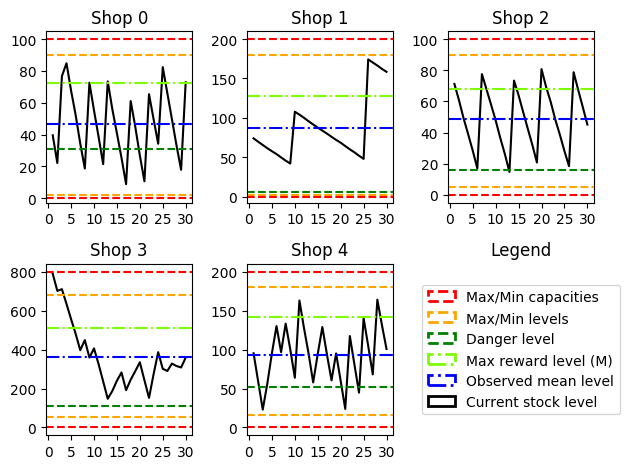

Total discounted rewards Level rewards Transport rewards
-0.008086355253361942 0.003437892629883849 0.029551324799999983
Average trucks sent:  43.0
1st type Trucks sent to each shop: [array([7, 1, 4, 5, 7, 6])]
2nd type Trucks sent to each shop: [array([ 1,  1,  0, 13,  4, 11])]


In [70]:
test_simulation(simulation_id= 24, max_episodes = 100000,n_episodes = test_episodes, noise = True)

### Stochastic consumption rates WITH transport/unload costs, 100K episodes 


Test episode: 1
Episode 1 t 0 -0.0008557 -0.0008557 0.0 5500
Episode 1 t 1 -0.0016277 -0.0004658 0.0011618 0300
Episode 1 t 2 -0.00102 2.63e-05 0.0010463 5400
Episode 1 t 3 2.09e-05 2.09e-05 0.0 5500
Episode 1 t 4 -0.0004713 9.21e-05 0.0005634 4500
Episode 1 t 5 0.000122 0.000707 0.000585 2500
Episode 1 t 6 -8.86e-05 2.69e-05 0.0001156 0500
Episode 1 t 7 0.0003285 0.0009027 0.0005742 1500
Episode 1 t 8 -0.0005476 1.58e-05 0.0005634 4500
Episode 1 t 9 -0.001048 0.0005616 0.0016096 4300
Episode 1 t 10 -0.0011394 2.24e-05 0.0011618 0300
Episode 1 t 11 -0.0004388 0.0001246 0.0005634 4500
Episode 1 t 12 -0.0016139 1.75e-05 0.0016313 2300
Episode 1 t 13 -0.0003707 0.0012498 0.0016205 1300
Episode 1 t 14 -0.0011312 3.06e-05 0.0011618 0400
Episode 1 t 15 -0.0010239 2.24e-05 0.0010463 5300
Episode 1 t 16 -0.0009885 5.78e-05 0.0010463 5300
Episode 1 t 17 -0.0002303 0.0003331 0.0005634 4500
Episode 1 t 18 -0.0006093 0.001022 0.0016313 2300
Episode 1 t 19 -0.0011279 3.39e-05 0.0011618 0400
Episode

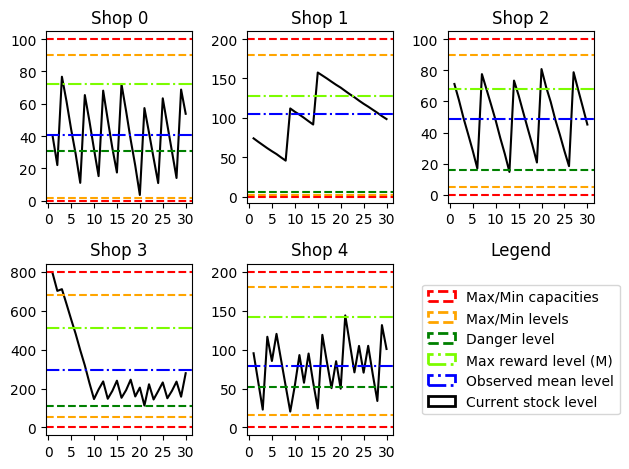

Total discounted rewards Level rewards Transport rewards
-0.006584294138030735 0.006124381718058664 0.028200672419999986
Average trucks sent:  40.0
1st type Trucks sent to each shop: [array([7, 2, 4, 2, 7, 8])]
2nd type Trucks sent to each shop: [array([ 0,  0,  0, 14,  4, 12])]


In [98]:
test_simulation(simulation_id= 19, max_episodes = 100000,n_episodes = test_episodes, noise = True)

Test episode: 1
Episode 1 t 0 -0.0008557 -0.0008557 0.0 5500
Episode 1 t 1 -0.0016277 -0.0004658 0.0011618 0300
Episode 1 t 2 -0.00102 2.63e-05 0.0010463 5400
Episode 1 t 3 2.09e-05 2.09e-05 0.0 5500
Episode 1 t 4 0.000136 0.000136 0.0 5500
Episode 1 t 5 0.0010982 0.0016832 0.000585 2500
Episode 1 t 6 -1.0005448 -0.9999814 0.0005634 4500
Episode 1 t 7 0.0007825 0.000898 0.0001156 0500
Episode 1 t 8 -0.0015952 1.44e-05 0.0016096 4300
Episode 1 t 9 0.0006319 0.0012061 0.0005742 1500
Episode 1 t 10 -0.001035 0.0001268 0.0011618 0400
Episode 1 t 11 -0.0009217 0.0001246 0.0010463 5300
Episode 1 t 12 -0.001497 0.0001343 0.0016313 2300
Episode 1 t 13 -0.0012797 0.00033 0.0016096 4300
Episode 1 t 14 -6.7e-06 0.0001088 0.0001156 0500
Episode 1 t 15 -0.0015858 2.38e-05 0.0016096 4300
Episode 1 t 16 -0.0009881 5.81e-05 0.0010463 5300
Episode 1 t 17 -0.0008824 -0.0008824 0.0 5500
Episode 1 t 18 0.0008927 0.001939 0.0010463 5400
Episode 1 t 19 -1.0011471 -0.9999853 0.0011618 0300
Episode 1 t 20 -0.

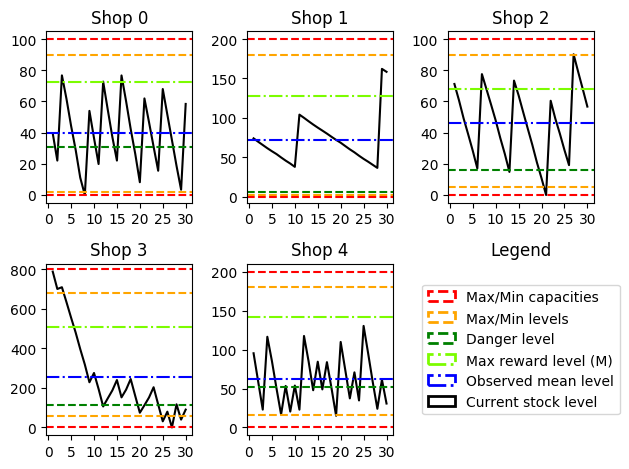

Total discounted rewards Level rewards Transport rewards
-0.7440444522246691 -2.9943062327856085 0.028630941359999985
Average trucks sent:  39.0
1st type Trucks sent to each shop: [array([ 7,  1,  3,  1,  7, 11])]
2nd type Trucks sent to each shop: [array([ 0,  1,  1, 14,  4, 10])]


In [72]:
test_simulation(simulation_id= 20, max_episodes = 100000,n_episodes = test_episodes, noise = True)

Test episode: 1
Episode 1 t 0 -0.0012746 -0.001159 0.0001156 0500
Episode 1 t 1 -0.0005347 2.87e-05 0.0005634 4500
Episode 1 t 2 2.31e-05 2.31e-05 0.0 5500
Episode 1 t 3 -0.0005423 2.11e-05 0.0005634 4500
Episode 1 t 4 -0.0001564 0.0004178 0.0005742 1500
Episode 1 t 5 0.0003345 0.0014963 0.0011618 0300
Episode 1 t 6 -0.0015924 3.9e-05 0.0016313 2400
Episode 1 t 7 2.69e-05 2.69e-05 0.0 5500
Episode 1 t 8 -0.0002422 0.0003212 0.0005634 4500
Episode 1 t 9 -0.0011343 2.75e-05 0.0011618 0300
Episode 1 t 10 -0.0005379 2.54e-05 0.0005634 4500
Episode 1 t 11 -0.0014848 0.0001248 0.0016096 3300
Episode 1 t 12 -0.000297 0.000288 0.000585 2500
Episode 1 t 13 -0.0003697 0.0007921 0.0011618 0300
Episode 1 t 14 -0.0005411 2.23e-05 0.0005634 4500
Episode 1 t 15 -0.0002492 0.0007971 0.0010463 5300
Episode 1 t 16 -0.0015016 0.000108 0.0016096 4300
Episode 1 t 17 9.74e-05 0.0006608 0.0005634 4500
Episode 1 t 18 -0.0019714 -0.0011718 0.0007997 2000
Episode 1 t 19 -0.0008026 0.000807 0.0016096 3300
Episod

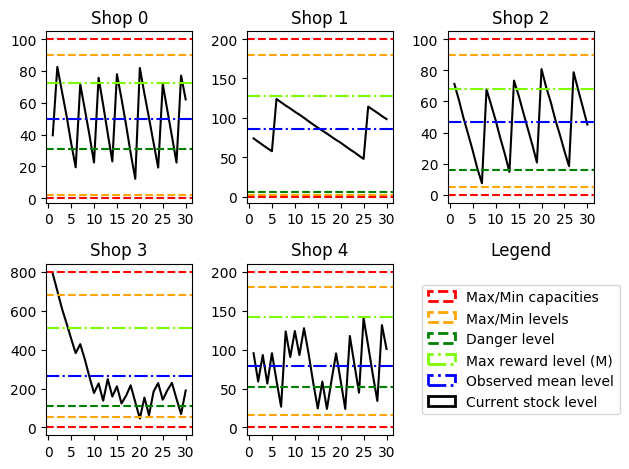

Total discounted rewards Level rewards Transport rewards
-0.005791199161845403 0.0069661389791771 0.028943582819999984
Average trucks sent:  42.0
1st type Trucks sent to each shop: [array([6, 2, 4, 5, 7, 6])]
2nd type Trucks sent to each shop: [array([ 1,  0,  0, 13,  4, 12])]


In [73]:
test_simulation(simulation_id= 25, max_episodes = 100000,n_episodes = test_episodes, noise = True)

In [74]:
a = '1200'

In [38]:
a[0].count('0')

0

In [41]:
np.zeros(n, dtype = np.int64)

array([0, 0, 0, 0, 0])

In [44]:
int(a[0])

1